# Counting Rings in Cropped Images - CycleGAN Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).

Here we'll take cropped images of antinodes and try to count the rings.

> NOTE: IceVision will supply bounding boxes for cropping never-before-seen images.  That seems to work ok.  Putting this all together into one workflow is... the next thing. ;-) 

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade

And import our libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

In [ ]:
#path = Path('/home/shawley/datasets/espiownage-cleaner/crops') # real physics data is local and private

# cyclegan fake data is public, for demo & reproducibility:  add force_download=True to grab a new version if needed
path = untar_data('http://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz') / 'crops'
print(path)

/home/shawley/.fastai/data/espiownage-cyclegan/crops


In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

3676 total cropped images


Path('/home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000654_94_3_269_148_2.0.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

2.0


In [ ]:
cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=label_func,
                   item_tfms=Resize(cropsize, ResizeMethod.Squish),
                   batch_tfms=[*aug_transforms(size=cropsize), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = croppedrings.dataloaders(path, bs=32)

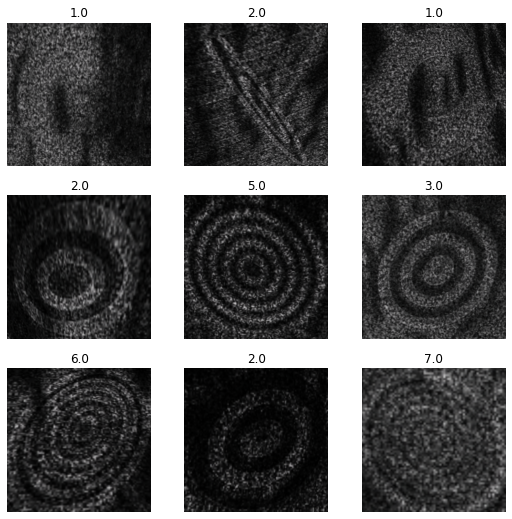

In [ ]:
dls.show_batch(max_n=9)

## Train model

We'll define something like accuracy:

In [ ]:
def acc_reg(inp, targ, bin_size=1):  # are they within +/- bin_size of each other?
    where_correct = (inp-targ).abs() < bin_size
    return where_correct.float().mean() 

def acc_reg05(inp, targ): return acc_reg(inp, targ, bin_size=0.5)
def acc_reg1(inp, targ): return acc_reg(inp, targ, bin_size=1)
def acc_reg15(inp, targ): return acc_reg(inp, targ, bin_size=1.5)
def acc_reg2(inp, targ): return acc_reg(inp, targ, bin_size=2)

In [ ]:
opt = ranger

In [ ]:
#PETS example learner:learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=MSELossFlat(), n_out=1, y_range=(0,11), opt_func=opt)#.to_fp16()

y_range=(0.5,11.5)  # try to stay in the semi-linear range of the sigmoid; our values are 1 to 11. 
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, metrics=[mae, acc_reg05,acc_reg1,acc_reg15,acc_reg2], loss_func=MSELossFlat(), opt_func=opt)

/home/shawley/envs/espi/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.009120108559727669)

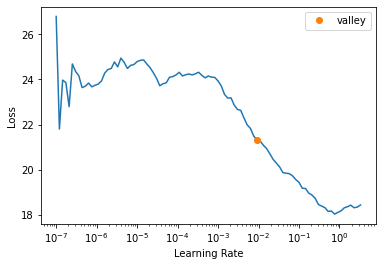

In [ ]:
learn.lr_find()

In [ ]:
#learn.fine_tune(10, 1e-2)
learn.fine_tune(20, 5e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,16.774862,11.088415,2.478420,0.131482,0.233540,0.331705,0.399006,00:15
1,10.613844,6.285766,1.852448,0.171253,0.281704,0.400931,0.469886,00:15


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,7.668365,4.571422,1.566711,0.178106,0.297240,0.411506,0.485788,00:19
1,6.382915,3.259998,1.318711,0.188991,0.319576,0.434555,0.511481,00:20
2,5.416741,2.587452,1.195722,0.199984,0.328768,0.457903,0.541590,00:20
3,4.686055,2.274418,1.124140,0.191802,0.332875,0.457133,0.542440,00:20
4,3.574872,2.802819,1.185424,0.185137,0.275724,0.416971,0.476684,00:20
5,2.521445,1.126852,0.672426,0.185924,0.312134,0.435791,0.523220,00:20
6,1.953588,0.587460,0.491107,0.184322,0.312263,0.442394,0.539147,00:20
7,1.489331,0.574417,0.496662,0.174988,0.307483,0.422257,0.515100,00:20
8,1.259251,0.475588,0.432043,0.187729,0.313605,0.448575,0.545955,00:20
9,1.210693,0.496231,0.430593,0.186630,0.321568,0.452159,0.547016,00:20


In [ ]:
learn.save('crop-rings-cg')

Path('models/crop-rings-cg.pth')

## Interpretation

In [ ]:
learn.load('crop-rings-cg');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
len(preds)

735

I'll define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {dls.valid.items[ind]}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([2.5370]), targs[0] = 2.0, loss = 0.2883443534374237
file = /home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000864_174_5_437_92_2.0.png
Image:


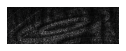

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
#preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
504,steelpan_0000100_28_129_155_266_7.0,7.0,11.28,18.320488,504
48,steelpan_0000917_176_25_343_228_7.0,7.0,11.00,16.033121,48
369,steelpan_0000354_86_96_241_249_7.0,7.0,10.72,13.825392,369
547,steelpan_0000547_271_62_442_279_8.0,8.0,11.50,12.249993,547
437,steelpan_0000059_245_149_378_300_8.0,8.0,11.50,12.249566,437


preds[504] = tensor([11.2802]), targs[504] = 7.0, loss = 18.32048797607422
file = /home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000100_28_129_155_266_7.0.png
Image:
preds[48] = tensor([11.0041]), targs[48] = 7.0, loss = 16.03312110900879
file = /home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000917_176_25_343_228_7.0.png
Image:
preds[369] = tensor([10.7183]), targs[369] = 7.0, loss = 13.82539176940918
file = /home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000354_86_96_241_249_7.0.png
Image:
preds[547] = tensor([11.5000]), targs[547] = 8.0, loss = 12.249993324279785
file = /home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000547_271_62_442_279_8.0.png
Image:
preds[437] = tensor([11.4999]), targs[437] = 8.0, loss = 12.249566078186035
file = /home/shawley/.fastai/data/espiownage-cyclegan/crops/steelpan_0000059_245_149_378_300_8.0.png
Image:


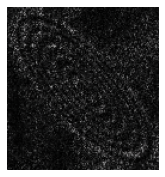

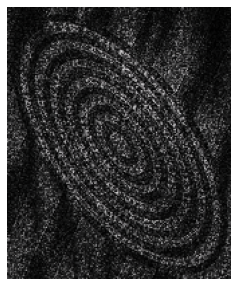

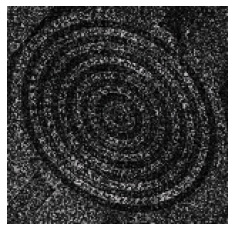

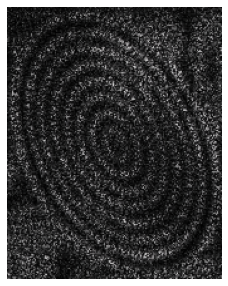

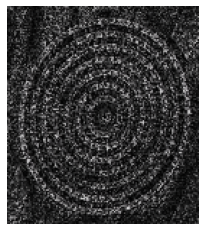

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

^ Wow those are pretty clear to the naked eye.  I wonder why this is hard for the CNN.


So then we can these results output into a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv('ring_count_top_losses_cg.csv', index=False)